### This notebook fits a BERTopic model to the data set and creates topic visualisations.

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

import nltk

nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk import TweetTokenizer
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/garethsmith/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Run these two lines to have all plots appear on GitHub (do not run to use interactive plots within this notebook):
import plotly.io as pio

pio.renderers.default = "png"

In [3]:
# Set directory and file paths
READ_DIR = "../data/processed"

FILENAME = "twitter_airline_sentiment_cleaned_emoji_urls_html_symbols@#_quotes_currency_whitespace"

EMBEDDING_MPNET = "twitter_airline_sentiment_cleaned_emoji_urls_html_symbols@#_quotes_currency_whitespace_all-mpnet-base-v2.npy"

In [4]:
# Load embeddings
embeddings_mpnet = np.load(f"{READ_DIR}/{EMBEDDING_MPNET}")

In [5]:
# Load text data
df = pd.read_csv(f"{READ_DIR}/{FILENAME}.csv")

#### Set customisable parameters for BERTopic components:

In [6]:
# Parameters for UMAP
n_neighbors = 15
n_components = 5
min_dist = 0.1
metric_umap = "cosine"
random_state = 0

# UMAP model
reducer = UMAP(
    n_neighbors=n_neighbors,
    n_components=n_components,
    min_dist=min_dist,
    metric=metric_umap,
    random_state=random_state,
)

# Parameters for HDBScan
min_cluster_size = 15
min_samples = 5
metric_hdbscan = "euclidean"
cluster_selection_method = "eom"

# HDBScan model
clusterer = HDBSCAN(
    min_cluster_size=min_cluster_size,
    min_samples=min_samples,
    metric=metric_hdbscan,
    cluster_selection_method=cluster_selection_method,
    prediction_data=True,
)

# The lower and upper boundary of the range of n-values for different word n-grams
# or char n-grams to be extracted:
ngram_range = (1, 2)

#### Create functions to fit BERTopic model:

In [13]:
def get_bertmodel(ngram_range, umap_model, hdbscan_model):
    # Convert a collection of text documents to a matrix of token counts:
    vectorizer = CountVectorizer(
        stop_words=stopwords.words("english"),
        tokenizer=TweetTokenizer().tokenize,
        token_pattern=None,
        ngram_range=ngram_range,
    )

    # Fit BERTopic model with customisation:
    topic_model = BERTopic(
        vectorizer_model=vectorizer, umap_model=umap_model, hdbscan_model=hdbscan_model
    )

    return topic_model


def get_topics_probs(model, docs, embeddings):
    topics, probs = model.fit_transform(docs, embeddings=embeddings)
    return topics, probs


def fit_bert(docs, embeddings, ngram_range, umap_model, hdbscan_model):
    bertmodel = get_bertmodel(
        ngram_range=ngram_range, umap_model=umap_model, hdbscan_model=hdbscan_model
    )

    topics, probs = get_topics_probs(model=bertmodel, docs=docs, embeddings=embeddings)

    return bertmodel, topics, probs

#### Fit BERTopic model using MPNET embeddings:

In [14]:
bertmodel_mpnet, topics_mpnet, probs_mpnet = fit_bert(
    docs=list(df.clean_text),
    embeddings=embeddings_mpnet,
    ngram_range=ngram_range,
    umap_model=reducer,
    hdbscan_model=clusterer,
)

##### Display the results table:
note: Topic -1 represents outliers 

In [15]:
df_bertopics_mpnet = bertmodel_mpnet.get_topic_info()
print("Number of topics: {}".format(len(df_bertopics_mpnet)))
df_bertopics_mpnet["Percentage"] = round(
    df_bertopics_mpnet["Count"] / df_bertopics_mpnet["Count"].sum() * 100, 2
)
df_bertopics_mpnet

Number of topics: 125


,Topic,Count,Name,Representation,Representative_Docs,Percentage
0,-1,7039,-1_flight_get_cancelled_thanks,"[flight, get, cancelled, thanks, plane, im, us...","[about time! Thank you!, too Late Flight now, ...",48.79
1,0,1061,0_bag_luggage_bags_baggage,"[bag, luggage, bags, baggage, lost, claim, lef...",[Really... .you charge me $25 to check a bag a...,7.35
2,1,362,1_hold_call_phone_minutes,"[hold, call, phone, minutes, hours, hung, hour...",[Was put on hold for 5.5 hrs then got a call b...,2.51
3,2,274,2_great_crew_great flight_attendant,"[great, crew, great flight, attendant, thanks,...","[Great flight, as always! Thank you to the gre...",1.90
4,3,184,3_hold_cancelled_cancelled flightled_flightled,"[hold, cancelled, cancelled flightled, flightl...",[been on hold for an hour. I need to rebook my...,1.28
...,...,...,...,...,...,...
120,119,15,119_apply_team job_job opening_recruiting,"[apply, team job, job opening, recruiting, isi...",[i hope i get the opportunity to join the team...,0.10
121,120,15,120_connection_phl_help delayed_miss,"[connection, phl, help delayed, miss, layover,...",[can you help me with a delayed flight as im g...,0.10
122,121,15,121_credit_purchased_refunded_receipt,"[credit, purchased, refunded, receipt, yr, dat...",[- He Cancelled Flightled a flight & was given...,0.10
123,122,15,122_worst experience_experience ever_worst_eve...,"[worst experience, experience ever, worst, eve...",[this has to be the absolute WORST EXPERIENCE ...,0.10


#### Choose a topic number and print data from the corresponding row:

In [39]:
topic_num = 0
for i, v in df_bertopics_mpnet.iloc[topic_num + 1].items():
    print(f"{i} : {v}")

Topic : 0
Count : 1061
Name : 0_bag_luggage_bags_baggage
Representation : ['bag', 'luggage', 'bags', 'baggage', 'lost', 'claim', 'left', 'checked', 'baggage claim', 'carry']
Representative_Docs : ["Really... .you charge me $25 to check a bag and then you put it on a different flight... .still Don't have my bag!!!", 'on top or having to check my bag I had to wait over 30 min for my bag to come out at baggage claim. Thanks for wasting my time', 'WHERE IS MY BAG?']
Percentage : 7.35


#### Show topic words and c-TF-IDF scores:

In [8]:
bertmodel_mpnet.get_topic(0)

[('bag', 0.030781032981964496),
 ('luggage', 0.020684293552515522),
 ('bags', 0.020381819082489937),
 ('baggage', 0.01744777224381253),
 ('lost', 0.014214952302093903),
 ('claim', 0.00891830076154246),
 ('left', 0.0074704102380880755),
 ('checked', 0.006990550643813577),
 ('baggage claim', 0.0063810018291119005),
 ('carry', 0.006343575507500414)]

##### For each topic, we can observe the most important words, sorted in decreasing order based on the c-TF-IDF score:

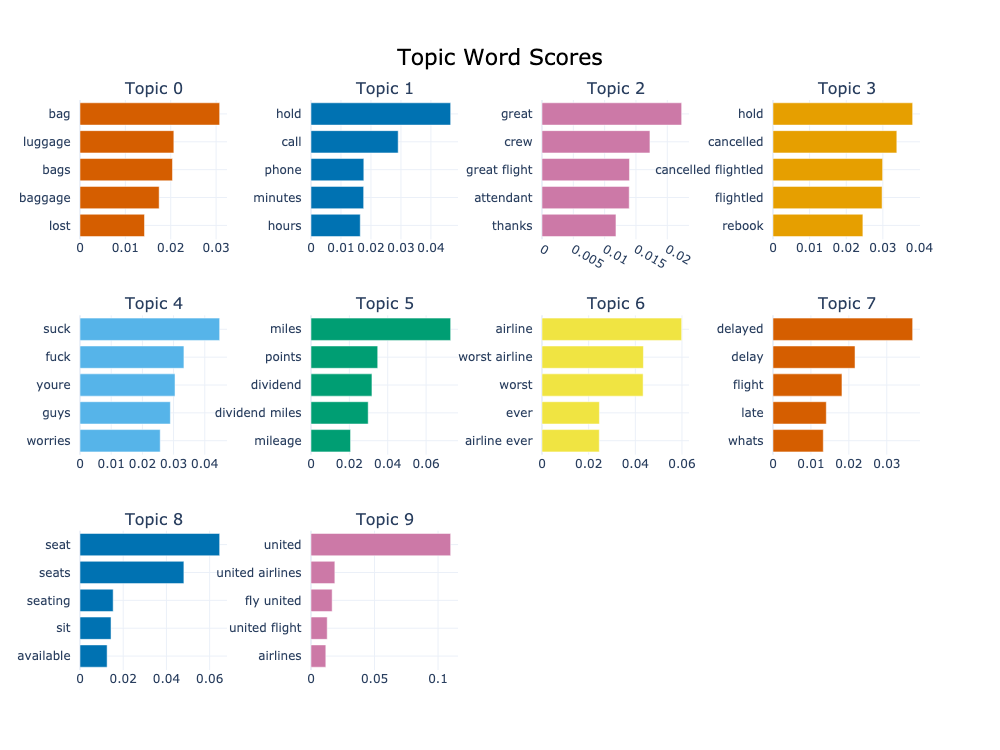

In [7]:
barchart = bertmodel_mpnet.visualize_barchart(top_n_topics=10)
barchart.show()

#### Create a 2D representation of the topics:

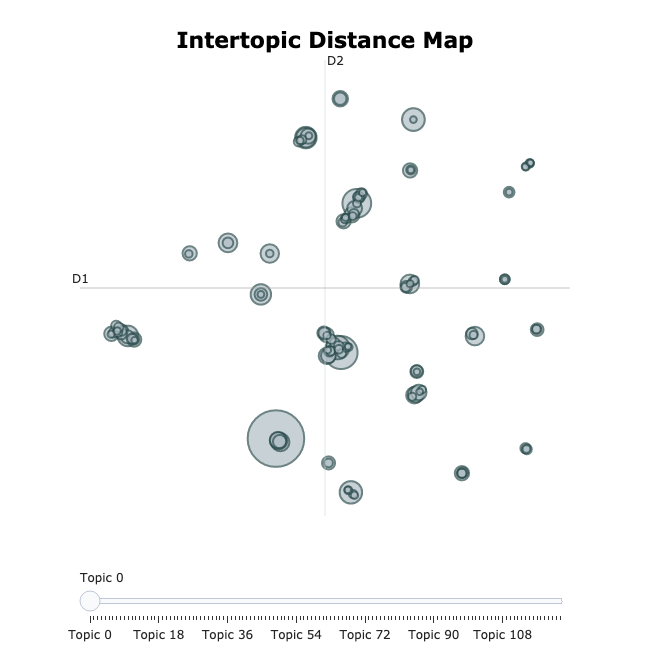

In [8]:
distance_map = bertmodel_mpnet.visualize_topics()
distance_map.show()

#### Visualise topic similarity with a heatmap:

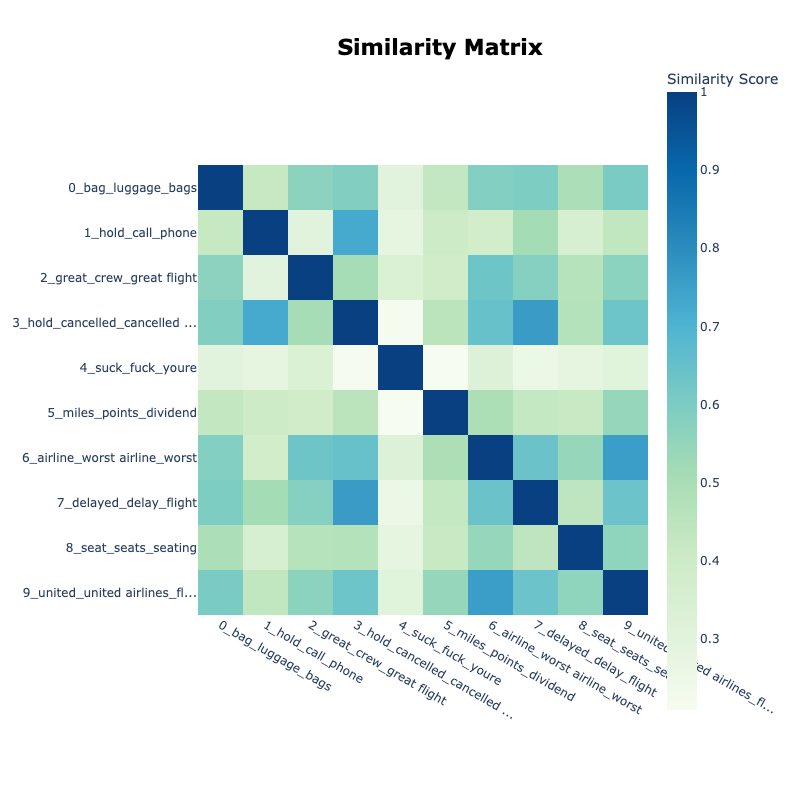

In [9]:
similarity_matrix = bertmodel_mpnet.visualize_heatmap(top_n_topics=10)
similarity_matrix.show()

#### Now visualise the documents within topics:

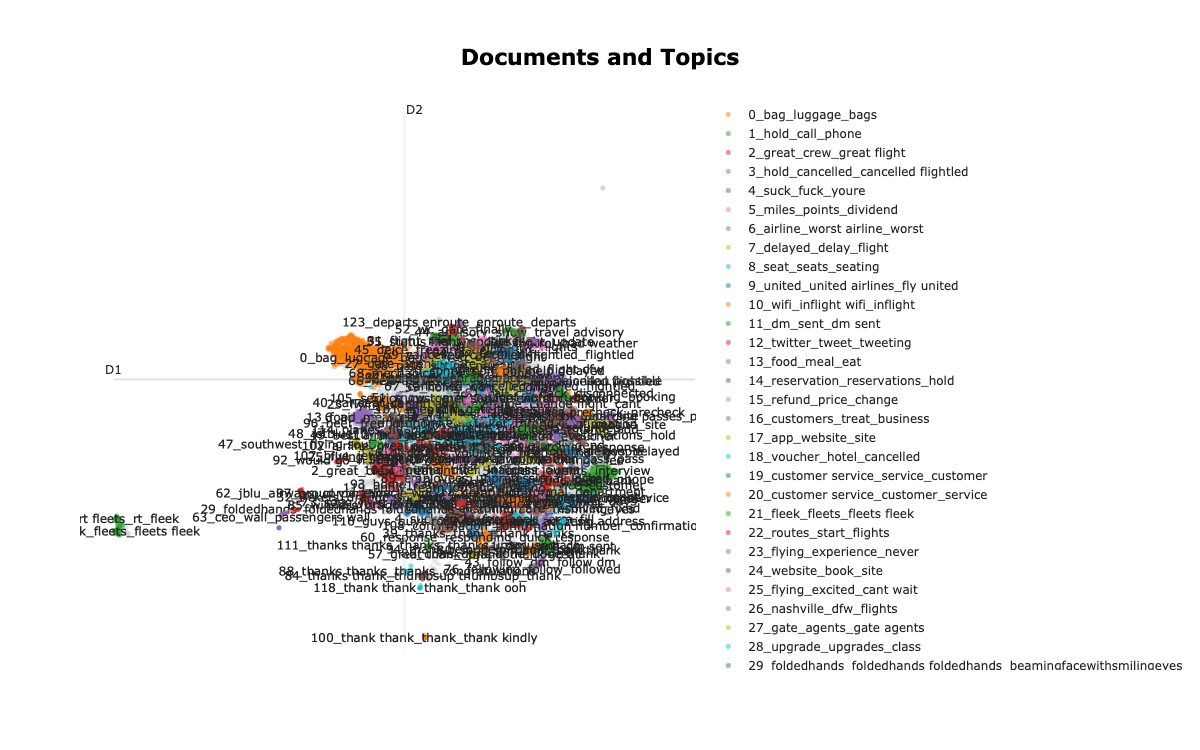

In [10]:
# Run the visualization with the original embeddings
# And viewing the original tweet text
bertmodel_mpnet.visualize_documents(docs=list(df.text), embeddings=embeddings_mpnet)

umap_vis = UMAP(
    n_neighbors=n_neighbors,
    n_components=2,
    min_dist=min_dist,
    metric=metric_umap,
    random_state=random_state,
)

# Reduce dimensionality of embeddings, this step is optional but much faster to perform iteratively:
reduced_embeddings = umap_vis.fit_transform(embeddings_mpnet)
bertmodel_mpnet.visualize_documents(
    docs=list(df.text), reduced_embeddings=reduced_embeddings
)

#### Visualise with wordclouds

In [9]:
def create_wordcloud(topic_model, topic):
    text = {word: value for word, value in topic_model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Topic" + " " + str(topic))
    plt.show()

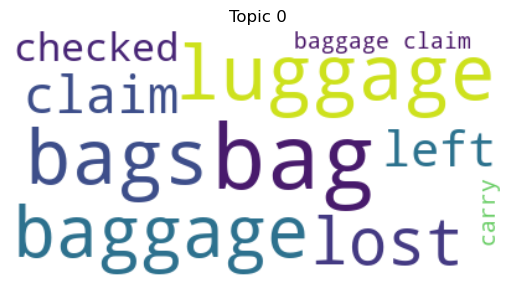

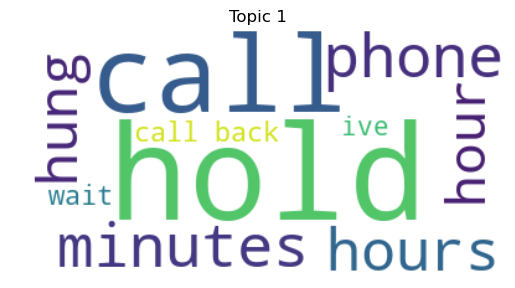

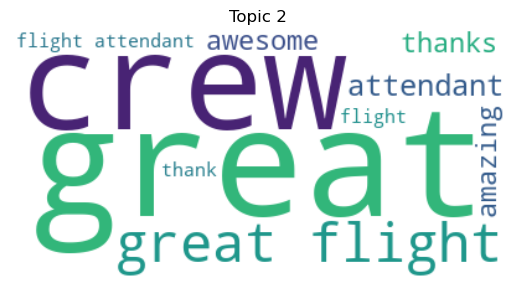

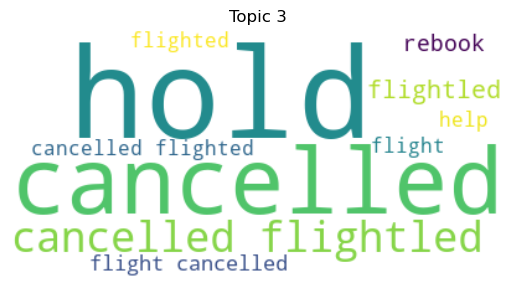

In [12]:
# Display the top 4 topics
for i in range(0, 4):
    create_wordcloud(bertmodel_mpnet, topic=i)

#### Save model:

In [52]:
# bertmodel_mpnet.save('../models/bertmodel_mpnet', save_embedding_model=True)

#### To load:

In [7]:
bertmodel_mpnet = BERTopic.load("../models/bertmodel_mpnet")